# Introduction

Before we can start working with the data, we must ensure the data is in a processable format.
To this end we will load the data, inspect and parse it, augment or retrofit values as much as possible and drop incomplete records


In [26]:
#Load essential data processing libraries...
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#pip install swifter
import swifter #allow multiprocessor .apply
%matplotlib inline

In [27]:
#We start by loading the raw data into a pandas dataframe
raw_data = pd.read_csv('../data/races.csv.gz',sep=';')

In [28]:
orig_len = len(raw_data)
raw_data.count()

id                  166609
race_created        166609
race_driven         166609
track_id            166609
challenger          166609
opponent            166609
money               166609
fuel_consumption    166609
winner              166609
status              166609
forecast            166609
weather             109099
dtype: int64

In [29]:
raw_data['id'].is_unique

True

We know that the id is unique across our dataset, so lets exchange it for the new index.

In [30]:
raw_data.set_index('id', inplace=True)

Let's inspect the data types pandas came up with...

In [31]:
raw_data.dtypes

race_created        object
race_driven         object
track_id             int64
challenger           int64
opponent             int64
money                int64
fuel_consumption    object
winner               int64
status              object
forecast            object
weather             object
dtype: object

Let's start to look at the fields individually now fields, we begin top down... 

## Cleaning: `race_created` and `race_driven`

In [32]:
# Let's parse the string representation as an actual datetime object
raw_data['cleaned_race_created'] = pd.to_datetime(raw_data.race_created, errors='coerce')

In [33]:
#Did we encounter any nonparseable dates?
np.isnat(raw_data.cleaned_race_created).sum()

0

No, perfect! Let's do the same for `race_driven`:

In [34]:
raw_data['cleaned_race_driven'] = pd.to_datetime(raw_data.race_driven, errors='coerce')

In [35]:
np.isnat(raw_data.cleaned_race_driven).sum()

57510

Unfortunately, here we had some erros parsing some values.
Let's take a look at some of the values, to understand what is going on

In [36]:
#Take a sample of 20 for race_driven and show it as a table
raw_data.sample(n=20)['race_driven'].head(n=20)

id
99301        29.12.2012 06:22
44063        18.07.2012 00:19
96537        20.12.2012 19:03
102594       08.01.2013 15:58
86226        03.12.2012 18:50
146043       30.10.2013 22:18
76312     0000-00-00 00:00:00
120823       11.04.2013 08:27
11763        28.03.2012 20:26
11201        24.03.2012 11:08
44933        21.07.2012 14:46
156833       05.07.2014 14:48
118432       31.03.2013 03:59
142093       22.09.2013 16:56
161821       12.12.2014 19:14
120760       11.04.2013 17:31
131050       05.06.2013 15:28
123185       24.04.2013 00:04
141325       15.09.2013 13:13
159589    0000-00-00 00:00:00
Name: race_driven, dtype: object

It seems a lot of them are just simply: `0000-00-00 00:00:00`

In [37]:
zero_values_racedriven = raw_data['race_driven'] == '0000-00-00 00:00:00'
zero_values_racedriven.sum()

57510

As a matter of fact, all of the non-parseable dates seem to have this `0000-00-00 00:00:00` format.

In [38]:
raw_data[zero_values_racedriven]['status'].value_counts()

retired     43224
declined    11392
waiting      2894
Name: status, dtype: int64

Looking at the `status` field, we can see that those are races that were not `finished`. Let's check if we had any of those states if a race was driven i.e. not `0000-00-00 00:00:00`...

In [39]:
raw_data[~(zero_values_racedriven)]['status'].value_counts()

finished    109099
Name: status, dtype: int64

We only find status finished here... So it is probably fine to keep this in the data as Not a time (NaT) for now since those races were not actually driven/finished.

In [40]:
#Are there any races where driven > created?
planned_before_driven =  raw_data['cleaned_race_driven'] < raw_data['cleaned_race_created']
raw_data[planned_before_driven]['status'].value_counts()

finished    4206
Name: status, dtype: int64

Those entries seems to be faulty. How can a race be planned/created after it has been driven?
Let's quantify and remove them from our resulting data set to be sure we do not get invalid data.

In [41]:
#How many percent are affected?
print("%.2f%% affected " % (100*len(raw_data[planned_before_driven])/len(raw_data)))

2.52% affected 


In [44]:
raw_data.drop(index=raw_data[planned_before_driven].index,inplace=True)

Let's have a look at the min and max time observed for both date values...

In [47]:
raw_data['cleaned_race_driven'].min(),raw_data['cleaned_race_driven'].max()

(Timestamp('2012-01-04 00:07:00'), Timestamp('2017-12-06 17:48:00'))

In [48]:
raw_data['cleaned_race_created'].min(),raw_data['cleaned_race_created'].max()

(Timestamp('2012-01-04 00:00:00'), Timestamp('2017-12-06 00:00:00'))

Those values seem sensible, and we do not seem to have any outliers.

In [50]:
raw_data.drop(columns=['race_driven','race_created'],inplace=True)

In [51]:
raw_data.dtypes

track_id                         int64
challenger                       int64
opponent                         int64
money                            int64
fuel_consumption                object
winner                           int64
status                          object
forecast                        object
weather                         object
cleaned_race_created    datetime64[ns]
cleaned_race_driven     datetime64[ns]
dtype: object

## Cleaning `track_id`

12    102392
3      37266
5      10277
8       2147
7       2113
4       1964
10      1768
13      1445
9        875
6        784
11       760
14       612
Name: track_id, dtype: int64

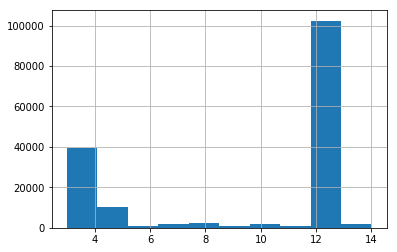

In [52]:
#Lets look if we need to clean track_id at all?
raw_data['track_id'].hist()
raw_data['track_id'].value_counts()

While some tracks (12) are much more popular than others, we do not seem to have a data problem. However, there is no point in using an integer type as the track id is clearly a categorical feature.

In [53]:
raw_data['track_id'] = raw_data['track_id'].astype('category')

## Cleaning `fuel_consumption`

In [54]:
raw_data.sample(n=20)['fuel_consumption'].head(n=20)

id
138107     81.375
131517      1.425
100453      0.375
128037      5.685
16938     02. Jul
20530       0.616
9995       Jan 89
161424     Apr 35
135883    01. Feb
153730     44.865
6534        1.335
153709     Apr 35
67756        0.78
166513     Mrz 18
166181      0.525
14180      Apr 38
166117      2.295
27335      Jul 59
105730     Apr 92
49442       4.425
Name: fuel_consumption, dtype: object

It seems some values here are dates without years, while other colums seems to be floating point numbers.

In [63]:
#Let's see how much we can parse. Maybe, this is not affecting many records in the dataset...
raw_data['cleaned_fuel_consumption'] = pd.to_numeric(raw_data['fuel_consumption'],errors='coerce')
#How many % records are affected?
bad_fuel_consumption = raw_data['cleaned_fuel_consumption'].isna()
print("%.2f%% affected" % (100*bad_fuel_consumption.sum()/len(raw_data['cleaned_fuel_consumption'])))

35.27% affected


In [66]:
#That is over 1/3 of our entire data set. We decide that this amount is too big to simply discard.
#Is this problem seems to affect only some race states as before?
raw_data[bad_fuel_consumption]['status'].value_counts()

finished    34567
retired     18603
declined     3402
waiting       712
Name: status, dtype: int64

In [68]:
#Are there more frequent outliers than, somewhere else?
raw_data[bad_fuel_consumption]['fuel_consumption'].value_counts()


Apr 35     24717
04. Mai     1106
02. Apr      843
03. Mrz      836
04. Feb      684
Mrz 54       670
03. Jun      640
01. Feb      599
Feb 55       576
02. Jul      552
Mrz 48       535
Mrz 81       533
01. Mai      528
03. Sep      514
Mrz 75       514
Mrz 15       466
Feb 85       453
02. Jan      423
Feb 61       419
Mrz 45       402
01. Aug      399
Jun 99       373
Apr 65       370
04. Aug      335
Jan 41       332
Jan 59       329
05. Jan      294
Feb 52       289
Apr 38       287
Feb 16       282
           ...  
Jun 71         1
Mrz 88         1
Okt 91         1
Jun 29         1
Jan 75         1
Jul 28         1
Mrz 44         1
Okt 97         1
Jun 22         1
Apr 34         1
Okt 49         1
Jan 55         1
Sep 79         1
03. Nov        1
Apr 82         1
04. Dez        1
Jun 95         1
Aug 57         1
Jan 57         1
Jul 18         1
Sep 24         1
Mrz 76         1
05. Dez        1
Jan 27         1
Mai 48         1
Jul 78         1
Apr 69         1
Mai 54        

Looking at the value we assume its the faulty interpretation of numeric values in a sheet calculator tool 
such as Microsoft excel, i.e., when the user has typed 4.35 the tool will interpret it as mm.yy, e.g. Apr 35
see [this](https://support.office.com/de-de/article/verhindern-der-automatischen-umwandlung-von-zahlen-in-datumswerte-d34b75d1-0867-45c0-b744-82a182a2433b)

Additionally, we find values such as `05. Dez`, here the program has interpreted the decimal as a date without a year present. That means `4.5` becomes `04. Mai`.

We spend quite a while searching for libraries that already implemented this kind of conversion functionality such as [xlrd](https://github.com/python-excel/xlrd), but did not succeed finding the required transformation. Thus, we implement the back-conversion ourself.

In [82]:
from calendar import month_abbr, different_locale

def get_month_name(month_no, locale):
    with different_locale(locale):
        return month_abbr[month_no]
    
german_month_abbr = [get_month_name(i,'de_DE') for i in range(1,13)]
german_month_abbr[2] = 'Mrz' #Excel uses Mrz instead of Mär, overwrite it...

def clean_fuel_cons(fuelcons_in):
    #If it can be converted out of the box, return it...
    converted = pd.to_numeric(fuelcons_in,errors='coerce')
    if not np.isnan(converted):
        return converted
    
    # Make sure subsequent array accesses do not fail...
    if len(fuelcons_in) <= 3:
        return np.NAN
    
    #abnormal case 1: Apr 35
    if fuelcons_in[:3] in german_month_abbr:
        before_decimal = german_month_abbr.index(fuelcons_in[:3]) + 1
        after_decimal = fuelcons_in[4:]
        return pd.to_numeric(str(before_decimal)+'.'+after_decimal)
    
    #abnormal case 2: 05. Jan
    elif fuelcons_in[-3:] in german_month_abbr and '.' in fuelcons_in:
        dot_index = fuelcons_in.index('.') + 1
        reconstructed_str = fuelcons_in[:dot_index] + str(german_month_abbr.index(fuelcons_in[dot_index+1:]))
        return pd.to_numeric(reconstructed_str)
    
    # Fall back to NAN
    return np.NAN
        
raw_data['cleaned_fuel_consumption'] = raw_data['fuel_consumption'].apply(clean_fuel_cons)

KeyError: 'fuel_consumption'

In [70]:
#Check if our conversion above left some edge-cases with NANs?
raw_data[np.isnan(raw_data['cleaned_fuel_consumption'])]['fuel_consumption']

Series([], Name: fuel_consumption, dtype: object)

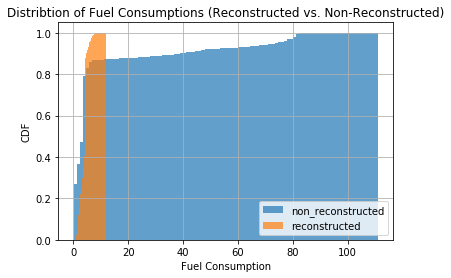

In [71]:
# Let's compare the distributions of both
hist_kwargs = {"cumulative":True, "density":1, "bins":100, "alpha":0.7}

ax = raw_data[~(bad_fuel_consumption)]['fuel_consumption'].astype(float).hist(label='non_reconstructed',**hist_kwargs)
raw_data[(bad_fuel_consumption)]['cleaned_fuel_consumption'].astype(float).hist(label='reconstructed', ax=ax, **hist_kwargs)

ax.set_ylabel('CDF')
ax.set_xlabel('Fuel Consumption')
ax.set_title("Distribtion of Fuel Consumptions (Reconstructed vs. Non-Reconstructed)")
ax.legend(loc='lower right')

We note that the distribtion of our reconstructed values is quite different, which however might be no suprise given the specific structure of the numbers that are eligble to be "convertable" into a date format.

In [72]:
raw_data.drop(columns=['fuel_consumption'],inplace=True)

## Cleaning `status`

In [73]:
raw_data.dtypes

track_id                          category
challenger                           int64
opponent                             int64
money                                int64
winner                               int64
status                              object
forecast                            object
weather                             object
cleaned_race_created        datetime64[ns]
cleaned_race_driven         datetime64[ns]
cleaned_fuel_consumption           float64
dtype: object

In [74]:
raw_data['status'] = raw_data.status.astype('category')

In [75]:
raw_data['status'].value_counts()

finished    104893
retired      43224
declined     11392
waiting       2894
Name: status, dtype: int64

## Cleaning `wheater`

In [76]:
raw_data['weather'] = raw_data.weather.astype('category')

In [77]:
raw_data['weather'].value_counts()

sunny       52620
rainy       26228
thundery    13076
snowy       12969
Name: weather, dtype: int64

In [78]:
#Double-Check if we have as much NaN records as we would expect for weather.
# I.e. if the status is not finished the weather is unknown (NaN)

pd.isna(raw_data['weather']).sum() == len(raw_data[raw_data['status'] != 'finished'])

True

Not much to do here... 

## Cleaning `prediction`

In [79]:
#There is no need to reinvent the wheel, 
#lets use phpserialize to avoid writing a parser of the serialization format ourselves...
#pip install phpserialize
from phpserialize import loads
import operator

In [83]:
possible_weather_keys = ['sunny','rainy','thundery','snowy']

def apply_deserialization(row):
    vals = loads(row['forecast'].encode('utf-8'),charset='utf-8',decode_strings=True)
    for key in possible_weather_keys:
        if key not in vals.keys():
            vals[str(key)] = np.NaN
    
    forecast = max(vals.items(), key=operator.itemgetter(1))[0]
    forecast_pct = max(vals.items(), key=operator.itemgetter(1))[1]
    
    return pd.Series([vals[k] for k in possible_weather_keys]+[forecast,forecast_pct])

raw_data[['forecast_'+i for i in possible_weather_keys]+['forecasted_wheater','forecasted_confidence']] = raw_data.swifter.apply(apply_deserialization,axis=1,result_type='expand')

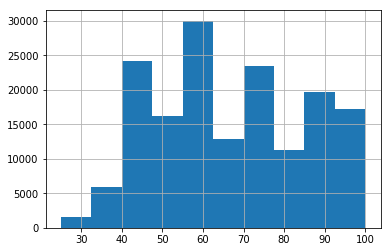

In [84]:
#Plot a histogram of the forecast significance to check if we have outliers < 0 or > 100
raw_data['forecasted_confidence'].hist()

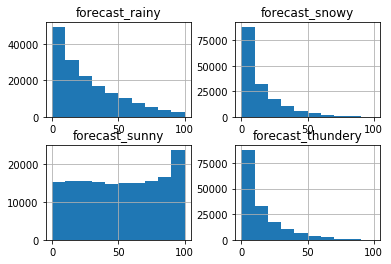

In [85]:
#How often is it rainy/sunny in general?
ax = raw_data[['forecast_'+i for i in possible_weather_keys]].hist()

In [86]:
#Sanity check the individidual confidences for the wheather
helper_sum_confidences = raw_data.swifter.apply(lambda x: sum(x[['forecast_'+i for i in possible_weather_keys]]),axis=1)

Pandas Apply:  13%|█▎        | 21848/162403 [00:15<01:35, 1472.24it/s]

limit_output extension: Maximum message size of 10000 exceeded with 10058 characters

In [89]:
helper_sum_confidences[helper_sum_confidences != 100]

Series([], dtype: int64)

We ensured the predicitons are always summing up to 100, while some wheater types are more common than others, this seems clean now.

In [90]:
raw_data.drop(columns=['forecast'],inplace=True)

KeyError: "labels ['forecast'] not contained in axis"

In [91]:
raw_data['forecasted_wheater'] = raw_data.forecasted_wheater.astype('category')

## Cleaning `opponent` and `challenger`

In [92]:
raw_data.dtypes

track_id                          category
challenger                           int64
opponent                             int64
money                                int64
winner                               int64
status                            category
weather                           category
cleaned_race_created        datetime64[ns]
cleaned_race_driven         datetime64[ns]
cleaned_fuel_consumption           float64
forecast_sunny                       int64
forecast_rainy                       int64
forecast_thundery                    int64
forecast_snowy                       int64
forecasted_wheater                category
forecasted_confidence                int64
dtype: object

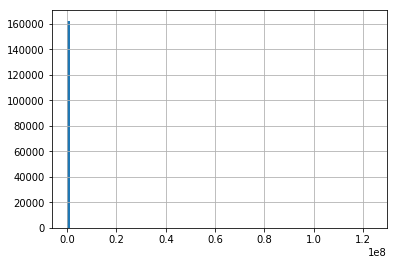

In [93]:
raw_data['opponent'].hist(bins=100)

In [94]:
raw_data['opponent'].nlargest(10)

id
72036     123456789
80216     123456789
47470      12345678
53795      12345678
82454         43000
82455         43000
82456         43000
82496         43000
166601        14656
166602        14656
Name: opponent, dtype: int64

So we seem to have 3 outliers `123456789`, `12345678` which are obviously bogus. ID `43000` also exceeds the range of regularly observed driver IDs. Thus we remove them all.

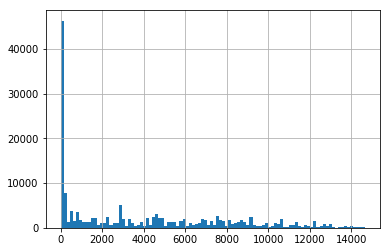

In [100]:
raw_data['challenger'].hist(bins=100)

Note how the distribution of challenger looks much different than opponent.

In [101]:
invalid_opponents = raw_data[(raw_data['opponent'] == 123456789) | (raw_data['opponent'] == 12345678) | (raw_data['opponent'] == 43000)]
invalid_opponents

,track_id,challenger,opponent,money,winner,status,weather,cleaned_race_created,cleaned_race_driven,cleaned_fuel_consumption,forecast_sunny,forecast_rainy,forecast_thundery,forecast_snowy,forecasted_wheater,forecasted_confidence
id,,,,,,,,,,,,,,,,


In [102]:
raw_data.drop(invalid_opponents.index,inplace=True)

In [107]:
max(raw_data['opponent'])

14656

This seems reasonable maximum.

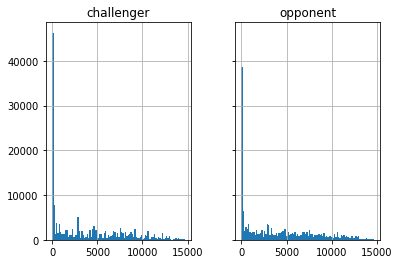

In [116]:
ax=raw_data[['opponent','challenger']].hist(bins=100,sharey=True)

However, we still have a lot of records where the opponent or the challenger is simply `0`.

In [117]:
challenger_or_opponent_zero = (raw_data['opponent'] == 0) | (raw_data['challenger'] == 0)
#How many percent are affected?
print("%.2f%% affected " % (100*len(raw_data[challenger_or_opponent_zero])/len(raw_data)))

9.35% affected 


Let's -again- look at the status of those races.

In [118]:
raw_data[challenger_or_opponent_zero]['status'].value_counts()

retired     15189
waiting         1
finished        0
declined        0
Name: status, dtype: int64

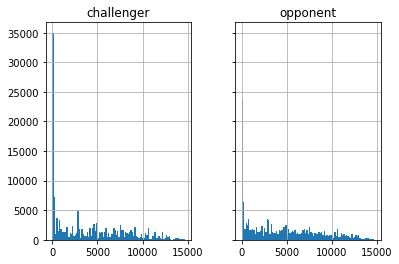

In [119]:
#It seems to only affect `retired` and `waiting`, races....
#Check what the distribution of other race types looks like for challenger and opponent.
ax = raw_data[~(challenger_or_opponent_zero)][['opponent','challenger']].hist(bins=100,sharey=True)


In [120]:
#something is still up with challenger...
raw_data[~(challenger_or_opponent_zero)]['challenger'].value_counts()[:20]

48       7435
2866     4470
46       4099
32       3631
5        2685
55       2380
148      2065
458      1718
1601     1374
2239     1365
9        1243
3        1186
4506     1137
9170     1058
47       1053
11313     966
543       940
740       931
4678      886
4710      876
Name: challenger, dtype: int64

What we can see is a typical power law distribution. Some heavy hitters are challengers with their `id < 100` (e.g. 48, 46, 32, 5, 55, 9, 3)

In [121]:
raw_data[~(challenger_or_opponent_zero)]['opponent'].value_counts()[:20]

48      3694
2866    2566
32      1887
55      1576
458     1154
148     1079
46      1057
3000    1046
4710     978
3317     960
9        922
740      895
47       871
81       857
130      843
4506     726
2239     726
5        673
117      669
63       636
Name: opponent, dtype: int64

Interestingly, it seems heavy-hitter challengers are also opponents frequently, however, they are challenging far more often than they are being challenged.

For now lets only note that fact,as this does not seems to be a cleaning problem right now so we only note this, but do not modify the data.

## Cleaning `money` (not what you think...)

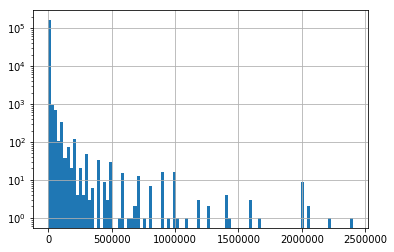

In [122]:
ax = raw_data['money'].hist(bins=100)
ax.set_yscale('log')

In [123]:
raw_data['money'].value_counts()[:10]

30      84737
50      33294
100     10102
1000     2940
500      2507
300      2231
200      1909
2000     1615
5000     1392
40       1242
Name: money, dtype: int64

In [124]:
#How many Percent only pay 30 eurs?
print("%.2f%% pay 30 EUR " % (100*len(raw_data[raw_data['money'] == 30])/len(raw_data)))
print("%.2f%% pay <= 50 EUR " % (100*len(raw_data[raw_data['money'] <= 50])/len(raw_data)))

52.18% pay 30 EUR 
73.98% pay <= 50 EUR 


*Note:* This indicates that there is some minimum fee of 30 EUR.
Again, cleaning wise this seems fine.

In [125]:
## Checking / Cleaning `winner`

In [130]:
#Do a sanity check for winner, is the winner populated on finished races, and is the winner a always a challenger or opponent?
finished_races = (raw_data['status'] == 'finished')
winner_is_opponent = (raw_data['opponent'] == raw_data['winner'])
winner_is_challenger = (raw_data['challenger'] == raw_data['winner'])
invalid_winners = raw_data[finished_races & ~( winner_is_opponent | winner_is_challenger)]
#Do we have any bogus records?
len(invalid_winners)

0

In [131]:
#Conversely, is the winner always 0 for non-finished races?
raw_data[~finished_races]['winner'].value_counts()

0    57502
Name: winner, dtype: int64

## Conclusion

In [134]:
#Our final datatypes...
raw_data.dtypes

track_id                          category
challenger                           int64
opponent                             int64
money                                int64
winner                               int64
status                            category
weather                           category
cleaned_race_created        datetime64[ns]
cleaned_race_driven         datetime64[ns]
cleaned_fuel_consumption           float64
forecast_sunny                       int64
forecast_rainy                       int64
forecast_thundery                    int64
forecast_snowy                       int64
forecasted_wheater                category
forecasted_confidence                int64
dtype: object

This concludes our cleaning section. We did not had to throw away only a couple of outliers.

In [144]:
#How many records did we throw away?

print("We had to discard %.2f%% (%d) records" % (100*(1-len(raw_data)/orig_len),orig_len-len(raw_data)))

We had to discard 2.53% (4214) records


In [143]:
#Let's export this to a feather file for later use in different notebooks!
export = raw_data.reset_index()
export.to_feather('../data/races.cleaned.feather')